<h2 id="Mihaly-Kollo">Mihaly Kollo</h2>
<h4>Principal Laboratory Research Scientist</h4>
<h2 id="Francis-Crick-Insitute"><span style="font-size: 18pt;">Francis Crick Insitute</span></h2>
<h2 id="kollom@crick.ac.uk"><span style="font-size: 18pt; color: #3598db;">kollom@crick.ac.uk</span></h2>
<p>&nbsp;</p>
<h1 id="NEURON-tutorial"><span style="text-decoration: underline;"><span style="font-family: Calibri, sans-serif; font-size: 24pt;">NEURON tutorial</span></span></h1>
<div class="alias" style="box-sizing: border-box; color: #212529; font-family: Montserrat, sans-serif; font-size: 16px; background-color: #ffffff;">
<p id="tinyurl.com/neurontutorial" class="text-break font-weight-bold" style="box-sizing: border-box; font-weight: bold; overflow-wrap: break-word;"></p>
</div>

<p><span style="font-size: 18pt; color: #3598db;">tinyurl.com/neurontutorial</span></p>

<h2>Checking if everyting is installed</h2>

In [453]:
import sys

print("The Python version of this kernel is: " + sys.version)

The Python version of this kernel is: 3.9.6 (default, Aug  5 2022, 15:21:02) 
[Clang 14.0.0 (clang-1400.0.29.102)]


In [454]:
!nrniv --version

NEURON -- VERSION 8.2.1 HEAD (c1590692) 2022-08-09


In [455]:
import neuron

print("The installed neuron version for Python is: " + neuron.__version__)

The installed neuron version for Python is: 8.2.1


In [456]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

<h2>Neuron basics</h2>

<p>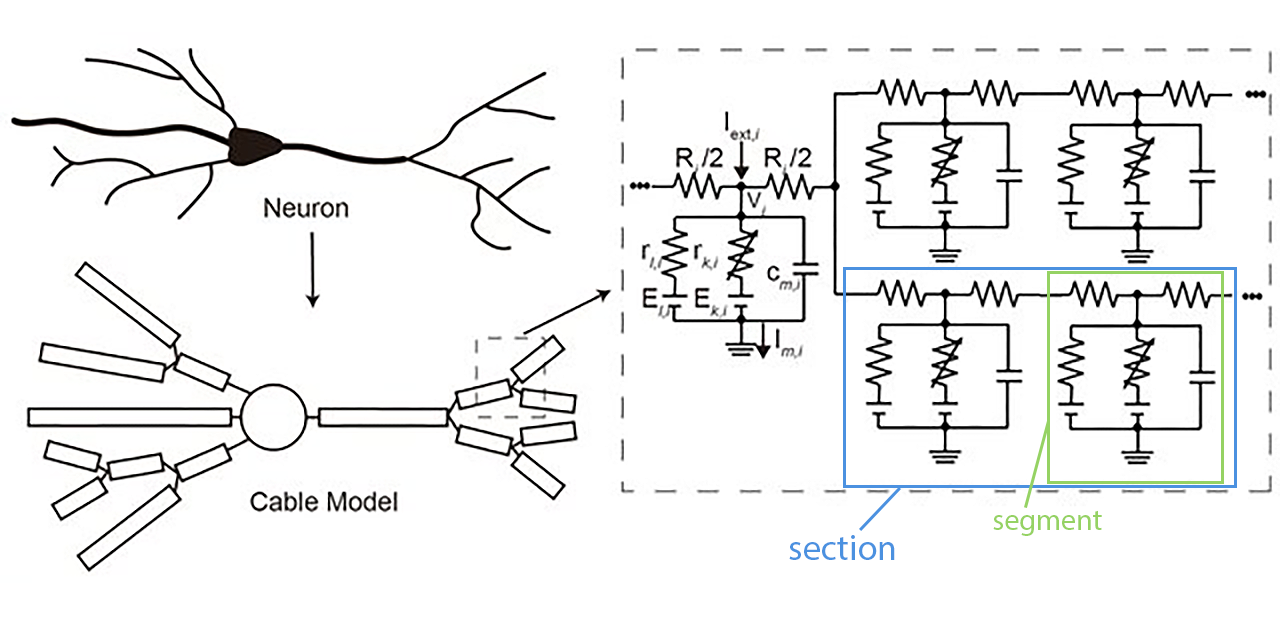</p>

<p><img src="https://neuron.yale.edu/neuron/static/docs/neuronpython/_images/python_hoc_neuron.png" alt="NEURON + Python Basics &mdash; NEURON + Python Tutorials 7.5 documentation" /></p>

<p><a href="https://senselab.med.yale.edu/ModelDB/" target="_blank" rel="noopener">ModelDB</a></p>
<p>&nbsp;</p>
<p><a href="https://nrn.readthedocs.io/en/latest/python/index.html" target="_blank" rel="noopener">https://nrn.readthedocs.io/en/latest/python/index.html</a></p>
<p>&nbsp;</p>
<p><a href="https://www.neuron.yale.edu/phpBB/search.php" target="_blank" rel="noopener">https://www.neuron.yale.edu/phpBB/search.php</a></p>


<h2>☐ Make a ball model and measure Ri, mTau with current injection</h2>

<p>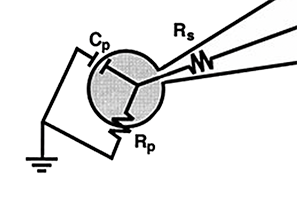</p>

In [1]:
from neuron import h, gui
from neuron.units import mV, ms

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
def clear_all_section():
    for sec in h.allsec():
        h.delete_section(sec=sec)

In [22]:
section = h.Section(name="soma")

In [4]:
section.psection()
section.L = 40
section.diam = 40

In [23]:
h.topology()


|-|       soma(0-1)
|-|       soma(0-1)



1.0

In [6]:
section.insert("pas")
section.g_pas = 0.0001


In [7]:
section.psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [0.0001], 'e': [-70.0], 'i': [0.0]}},
 'ions': {},
 'morphology': {'L': 40.0,
  'diam': [40.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x7fa868040000',
 'cell': None}

In [26]:
def sim_voltage_response(segment, i_stim, v_init=-70, tstop=400):
    voltage = h.Vector()
    voltage.record(segment._ref_v)
    
    stim = h.IClamp(segment)
    stim.delay = tstop/4
    stim.dur = tstop/4
    stim.amp = i_stim
    
    current = h.Vector()
    current.record(stim._ref_i)
    
    t = h.Vector()
    t.record(h._ref_t)
    h.tstop = tstop
    h.v_init = v_init
    h.run()
    return t, voltage, current

def plot_voltage_response(t, voltage, current, title=""):
    f, (ax_v, ax_c) = plt.subplots(2, 1, figsize=(5,3), gridspec_kw={'height_ratios':[3, 1]})
    ax_v.plot(t, voltage, "darkblue")
    ax_c.plot(t, current, "crimson")
    
    ax_v.set_ylabel("Voltage (mV)")
    ax_v.spines['right'].set_visible(False)
    ax_v.spines['top'].set_visible(False)
    ax_v.spines['bottom'].set_visible(False)
    ax_v.get_xaxis().set_visible(False)
    
    ax_c.set_ylabel("Current (nA)")
    ax_c.set_xlabel("Time (ms)")
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    f.suptitle(title)
    
    

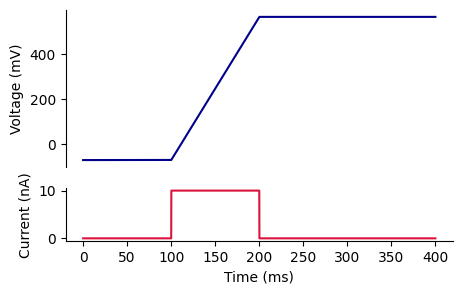

In [28]:
t, voltage, current = sim_voltage_response(section(0.5), 10)
plot_voltage_response(t, voltage, current)

(16001,)

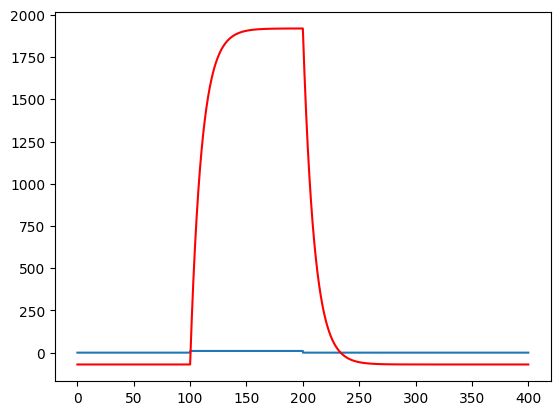

In [13]:
plt.plot(t, current)
plt.plot(t, voltage, 'r')


<h2>Change diameter, Rm, Ra, Cm and see how it affects Ri and mTau</h2>

<h2>Add dendrites and axons of increasing total areas. What happens to Ri and mTau? Pay special attention to whether mTau is a single exponential.</h2>

<h2>Add HH Na and K voltage-gate channel to the ball model and inject current steps (add one at the time to see the effect of each one, and then combine)</h2>

<h2>Measure gNa and gKv as a function of current injection at the soma, and plot activation curves (from resting Vm)</h2>

<h2>Measure gNa and gKv to a large current step from increasing resting Vms, and plot inactivation curves.</h2>

<h2>Give two large current steps separated by an increasing time interval, and plot gNa. What happens?</h2>

<h2>Synaptic integration</h2>

<h2>Add a single alpha excitatory synapse in the soma and then in the dendrite, progressively further away, and record at the soma. What changes?</h2>

<h2>Do the same but record at the dendrite where the synapse is. How does it compare to the soma? What changes with distance?</h2>

<h2>Change Rm, Cm and Ra - how does it affect the EPSP locally and at the soma?</h2>

<h2>In a model with dendrites, compare the somatic EPSPs generated by 10 synapses in the same dendritic location versus 10 synapses in different dendritic branches.</h2>

<h2>Repeat in the presence of NMDA receptors. What changes?</h2>

In [ ]:
# https://senselab.med.yale.edu/ModelDB/showmodel?model=18198&file=/SYN_NEW/nmda.mod#tabs-2
